### Import libraries

In [35]:
from typing import Annotated, Sequence, TypedDict
from dotenv import load_dotenv
from IPython.display import display, Image
from langchain_core.tools import tool
from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    SystemMessage,
    ToolMessage,
)
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import tools_condition, ToolNode
from langgraph.prebuilt.chat_agent_executor import AgentState

### Load environment variables

In [36]:
load_dotenv()

True

### Define tools

In [37]:
@tool
def add(x: int, y: int) -> int:
    "Add two integers and return the sum."

    return x + y


@tool
def subtract(x: int, y: int) -> int:
    "Subtract two integers and return the difference."

    return x - y


@tool
def multiply(x: int, y: int) -> int:
    """Multiply two integers and return the product."""

    return x * y


@tool
def divide(x: int, y: int) -> int:
    "Divide two integers and return the quotient."

    return int(x / y)


tools = [add, subtract, multiply, divide]

### Define LLM Agent

In [38]:
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash", temperature=0).bind_tools(tools)

### Define components

In [39]:
def invoke_agent(state: AgentState) -> AgentState:
    """AI chatbot"""

    system_message = SystemMessage("You are a helpful AI assistant.")
    response = llm.invoke([system_message] + state["messages"])
    return {"messages": [response]}

### Create graph

In [40]:
# Initialize graph
graph = StateGraph(AgentState)

# Add nodes
graph.add_node("Agent", invoke_agent)
tool_node = ToolNode(tools=tools)
graph.add_node("tools", tool_node)

# Add edges
graph.add_edge(START, "Agent")
graph.add_conditional_edges("Agent", tools_condition)
graph.add_edge("tools", "Agent")

# Compile the graph
app = graph.compile()

### Display graph

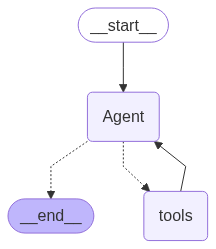

In [41]:
display(Image(app.get_graph().draw_mermaid_png()))

### Invoke agent

In [42]:
# Define your input messages
input = {
    "messages": [
        HumanMessage(
            content="Add 6 and 3, then multiply the result by 4, then divide it by 3 and subtract 1 from it. Also, tell me a joke."
        )
    ]
}

# If you don't need streaming, just get the final result
for chunk in app.stream(input):
    for messages in chunk.values():
        if isinstance(messages, dict) and "messages" in messages:
            messages["messages"][-1].pretty_print()
        elif hasattr(messages, "pretty_print"):
            messages.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  add (e07c2a11-d19a-4c79-af37-cc4e24c01931)
 Call ID: e07c2a11-d19a-4c79-af37-cc4e24c01931
  Args:
    y: 3.0
    x: 6.0
================================= Tool Message =================================
Name: add

9
================================== Ai Message ==================================
Tool Calls:
  multiply (5413a7b7-3848-4f07-ba3b-c84af724f66a)
 Call ID: 5413a7b7-3848-4f07-ba3b-c84af724f66a
  Args:
    y: 4.0
    x: 9.0
================================= Tool Message =================================
Name: multiply

36
================================== Ai Message ==================================
Tool Calls:
  divide (37832865-a0ab-4302-a0a8-815eac8ad171)
 Call ID: 37832865-a0ab-4302-a0a8-815eac8ad171
  Args:
    y: 3.0
    x: 36.0
================================= Tool Message =================================
Name: divide

12
================================== Ai Message ========